## Figures 4-6

The density plots show the correlation between the chromatin accessibility measured by ATAC-seq and the acetylation and methylation profiles which are related to Acetyl-CoA and SAM fluxes.

In [25]:
import pandas as pd
import numpy as np
import cobra
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, norm
import time
from numpy.polynomial.polynomial import polyfit
import scipy
import random

In [3]:
#upload files
#RNA-seq from Kuang et al. (2014) 
fpkm=pd.read_csv("./KuangRNAseq_15.csv",index_col=0)

#ATAC-seq from Gowans et al. (2018)
atac=pd.read_csv("GSE101290_normalized_atac_counts.csv",index_col=0)

#stages YMC from Kuang et al. (2014)
OX= pd.read_csv("kuangOX.txt", sep="\t")
RB= pd.read_csv("kuangRB.txt", sep="\t")
RC= pd.read_csv("kuangRC.txt", sep="\t")

#Fluxes of ACOA and SAM from Pheflux2.0
ACOA_all=pd.read_csv("./vectorAC_15flux.csv",index_col=0)
SAM_all=pd.read_csv("./vectorME_15flux.csv",index_col=0)

#ChIP-seq from Kuang et al. (2014)
H3K9ac=pd.read_csv("./dfi_T_15_ac.csv", index_col=0)
H3K4me3=pd.read_csv("./dfi_T_15_me.csv", index_col=0)

In [4]:
#Get average between the different elements of replicates 1, 2; 3. 4; 5, 6.
genes=atac.index
T1=list((atac.iloc[: , 1].values+atac.iloc[: , 2].values)/2)
T2=list((atac.iloc[: , 3].values+atac.iloc[: , 4].values)/2)
T3=list((atac.iloc[: , 5].values+atac.iloc[: , 6].values)/2)
T4=list((atac.iloc[: , 7].values+atac.iloc[: , 8].values)/2)
T5=list((atac.iloc[: , 9].values+atac.iloc[: , 10].values)/2)
T6=list((atac.iloc[: , 11].values+atac.iloc[: , 12].values)/2)

In [5]:
#Make df from the lists made with the averages of the replicates
import pandas as pd
import numpy as np
lst1 = genes
lst2 = T2 # RC
lst3= T3  # OX
lst4= T4  # OX
lst5= T5  # RB
lst6= T6  # RB
lst7= T1  # RC
atac_prom = pd.DataFrame(list(zip(lst1,lst2,lst3,lst4,lst5,lst6,lst7)), columns = ['Genes','T1','T2','T3','T4','T5','T6'])
#set the gene.id column as index to make the heatmap
df_atac = atac_prom.set_index(['Genes'])

In [6]:
#Define lists with genes by stage
lista_RC=list(RC.iloc[0:-2,0])
lista_OX=list(OX.iloc[0:-2,0])
lista_RB=list(RB.iloc[0:-2,0])

In [7]:
lista_RC_ss=[]
for gene in lista_RC:
    if gene in atac.index:
          lista_RC_ss.append(gene)

lista_OX_ss=[]
for gene in lista_OX:
    if gene in atac.index:
          lista_OX_ss.append(gene)
            
lista_RB_ss=[]
for gene in lista_RB:
    if gene in atac.index:
          lista_RB_ss.append(gene)

In [8]:
from scipy import stats
   
#Calculation of the correlation between the precursor and the epigenetic mark
def ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa):
    # subsets the dataframe
    df = marcaEpigenetica.loc[genesEtapa]
    # Computes the correlation
    corr=[]
    randomCorr=[]
    for i in range(len(df)):
        a = np.array(df.iloc[i,:])
        b = np.array(perfilPrecursor)[0]
        corr.append(stats.pearsonr(a,b)[0])
        # Random shuffle
        random.shuffle(a)
        random.shuffle(b)
        randomCorr.append(stats.pearsonr(a,b)[0])    
    #order correlation from highest to lowest
    df_corr=pd.DataFrame(corr,index =df.index,columns = ['correlation'])
    corr_sort = df_corr.sort_values('correlation',ascending=False)

    return(corr_sort,randomCorr)


0.3642480466683787 1.0746095444531301e-162


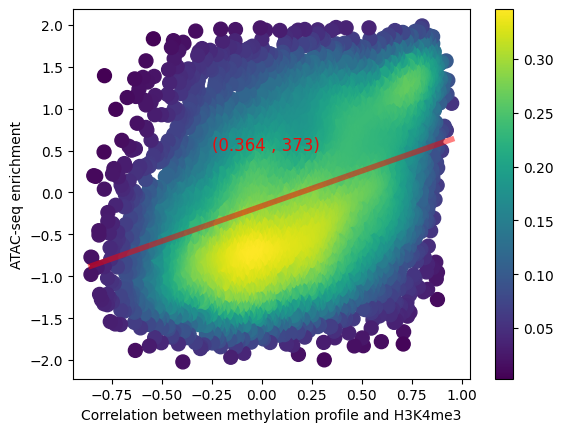

In [9]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsMe = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsMe=corrs

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)
label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_1me_all.svgz")

0.18116814303191392 1.4648318286670791e-39


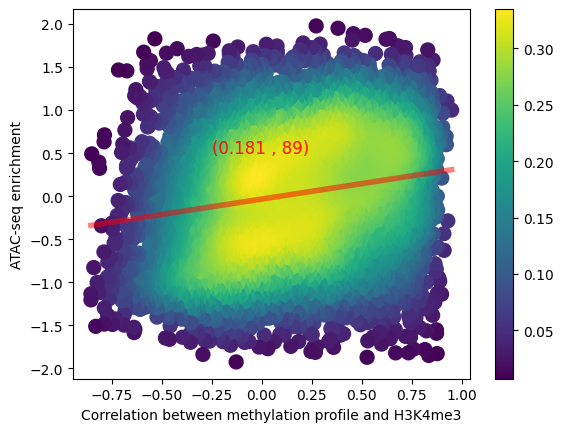

In [10]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsMe = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsMe=corrs


dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)

label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_2me_all.svgz")

-0.0909500014459064 5.1644621934814e-11


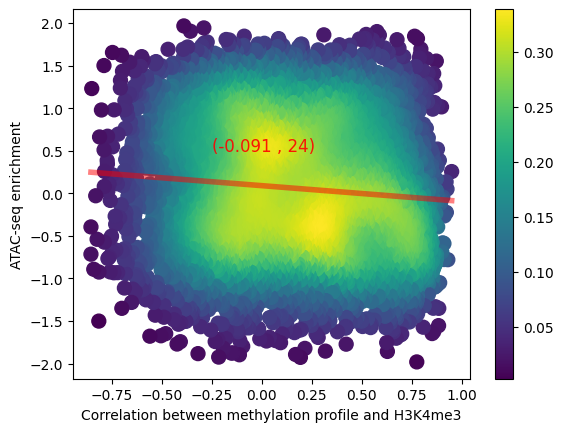

In [11]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsMe = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsMe=corrs


dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)

label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_3me_all.svgz")

-0.26872774910355807 1.3304051686379747e-86


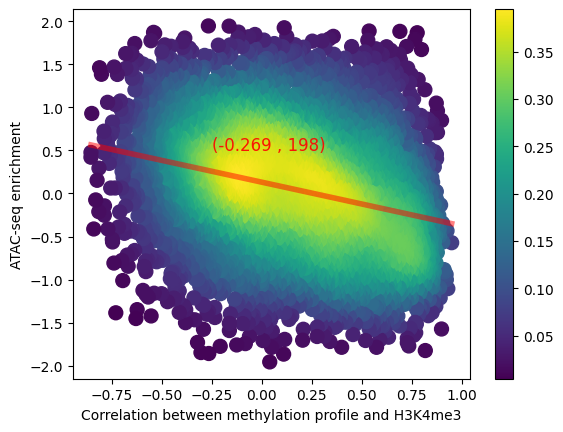

In [12]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsMe = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsMe=corrs


dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)

label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_4me_all.svgz")

-0.16378446803584168 1.5004620953289247e-32


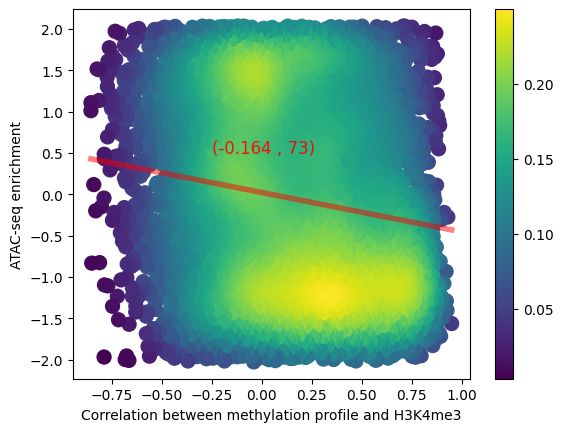

In [13]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsMe = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsMe=corrs


dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)

label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_5me_all.svgz")

-0.012634533086915518 0.362668091120376


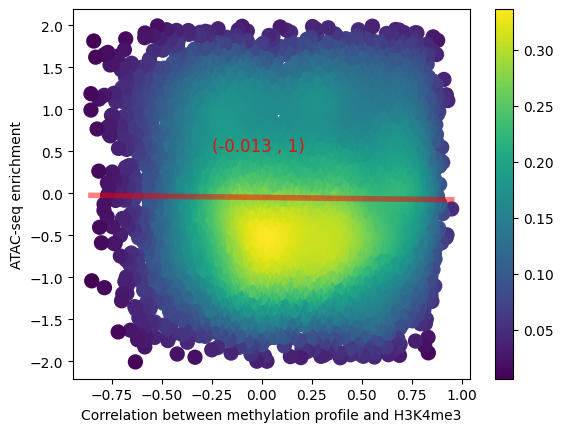

In [14]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsMe = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsMe=corrs


dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)

label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_6me_all.svgz")

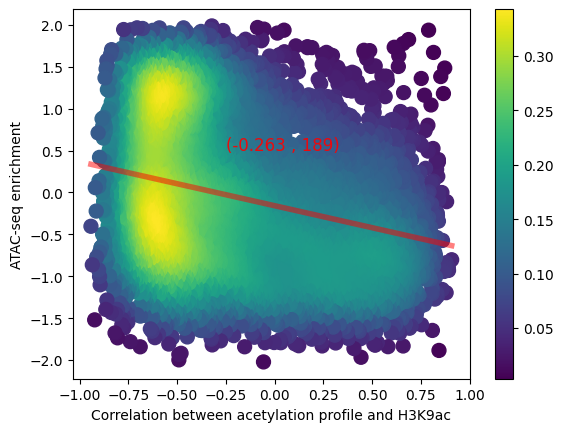

In [15]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsAc = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsAc = corrs


dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 


# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5,label=label)
r,p=scipy.stats.pearsonr(x, y)
label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
 
plt.savefig("corr_1ac_all.svgz")

-0.3975190615549268 3.6590616918616154e-196


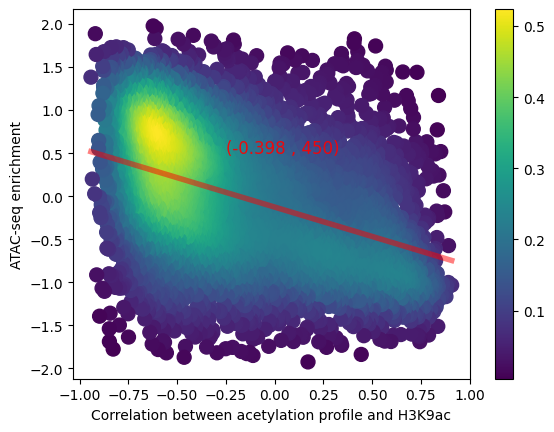

In [16]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsAc = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsAc = corrs

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)


# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)
r,p=scipy.stats.pearsonr(x, y)
label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_2ac_all.svgz")

-0.1851973582392576 2.7202544303244556e-41


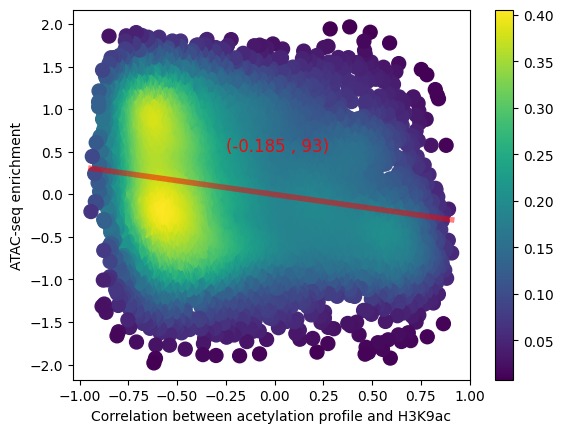

In [17]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsAc = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsAc = corrs

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)


# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)
r,p=scipy.stats.pearsonr(x, y)
label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_3ac_all.svgz")

0.1827119316708984 3.215512405879064e-40


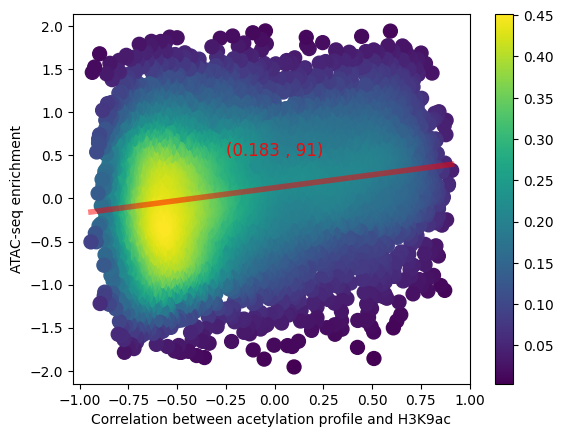

In [18]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsAc = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsAc = corrs

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate data
x = corrs
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)
r,p=scipy.stats.pearsonr(x, y)
label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_4ac_all.svgz")

0.27164499767759004 1.593836202263505e-88


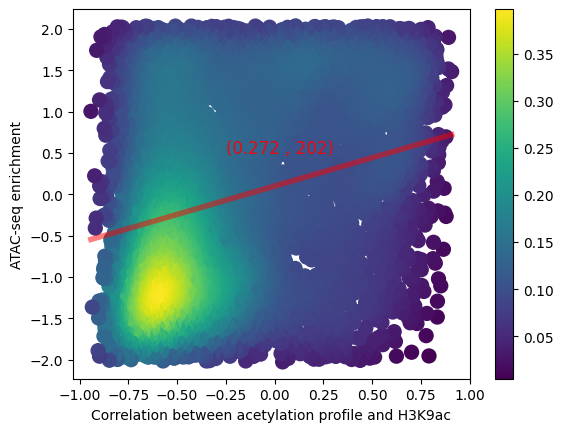

In [19]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsAc = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsAc = corrs

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)


# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)
r,p=scipy.stats.pearsonr(x, y)
label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_5ac_all.svgz")

0.2716349937705653 1.6183556485170217e-88


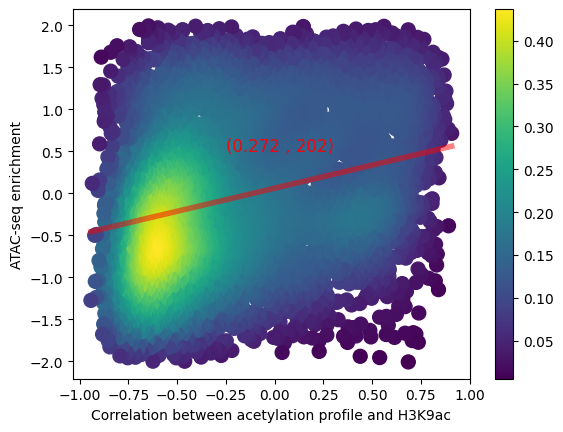

In [20]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados,randomCorrsAc = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]
corrsAc = corrs

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment")  

cbar = fig.colorbar(scatter)


# Fit with polyfit
b, m = polyfit(x, y, 1)
r,p=scipy.stats.pearsonr(x, y)
print(r,p)
plt.plot(x, b + m * x, '-',color="red",linewidth=4,alpha=0.5)
r,p=scipy.stats.pearsonr(x, y)
label="("+str(round(r,3))+" , "+str(round(-np.log(p)))+")"
plt.text(-0.25,0.5,label,color="red",fontsize=12,alpha=0.9)
plt.savefig("corr_6ac_all.svgz")

0.004215012402098784 0.06914467642114425
0.5249418135664562 106 1064 0.09962406015037593
-0.7500534531592415 2 26 0.07692307692307693


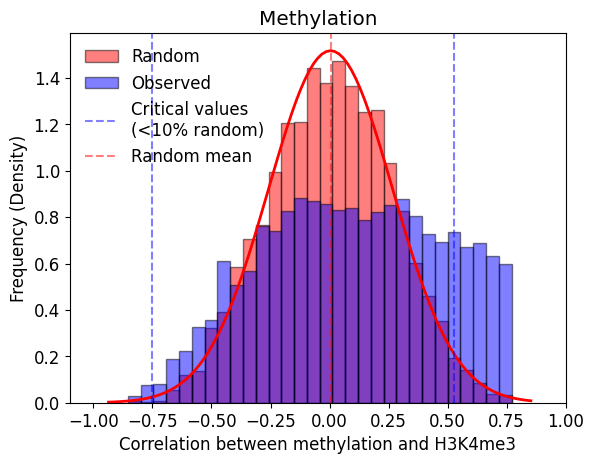

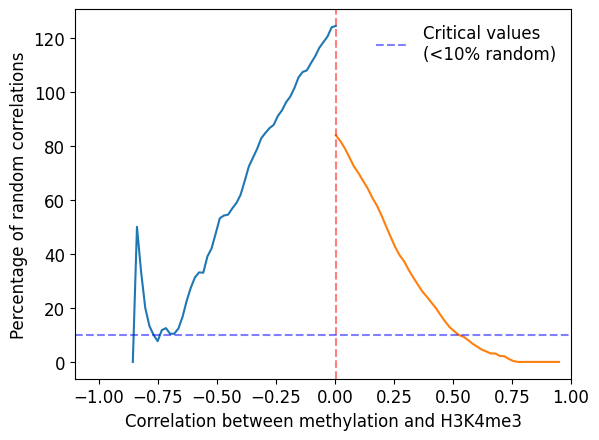

In [102]:
# Increase font sizes
plt.rcParams.update({'font.size': 12})  # Adjust the value as needed

# Generate some random data for the histogram (replace with your data)
random = randomCorrsMe
corrs = corrsMe

# Create the histogram
n,bins,patches=plt.hist(random, bins=30, density=True, alpha=0.5, color='red', edgecolor='black',label="Random")
plt.hist(corrs, bins=bins,density=True, alpha=0.5, color='blue', edgecolor='black',label="Observed")

# Generate x-values for the normal distribution curve
xmin, xmax = plt.xlim()  # Get the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# Calculate the normal distribution curve (mean=0, variance=1)
u=np.mean(random)
var=np.var(random,ddof=1)
p = norm.pdf(x, u,np.sqrt(var))  # norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, p, 'red', linewidth=2)#, label='Normal \ndistribution\n$\hat\mu$='+str(round(u,3))+'\n$\hat\sigma$='+str(round(var,3)))

# Example: Normal distribution with mean 0 and standard deviation 1 (standard normal)
mean = u
std_dev = np.sqrt(var)
alpha = 0.05
print(mean,var)

# Right
criticalsR=np.linspace(mean,max(corrs))
percentagesR=[]
show=True
for criticalR in criticalsR:
    a=np.sum(random >= criticalR)
    b=np.sum(corrs >= criticalR)
    percentagesR.append(a/b*100)
    if a/b<=0.1 and show==True: 
        print(criticalR,a,b,a/b)
        cRight = criticalR
        show = False
# Left        
criticalsL=np.linspace(mean,min(corrs))
percentagesL=[]
show=True
for criticalL in criticalsL:
    a=np.sum(random <= criticalL)
    b=np.sum(corrs <= criticalL)
    percentagesL.append(a/b*100)
    if a/b<=0.1 and show==True: 
        print(criticalL,a,b,a/b)
        cLeft = criticalL
        show = False

plt.axvline(x=cRight, color='b', linestyle='--',label="Critical values\n(<10% random)",alpha=0.5)
plt.axvline(x=cLeft, color='b', linestyle='--',alpha=0.5)
plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5,label="Random mean")
plt.xlim([-1.1,1])
plt.xlabel('Correlation between methylation and H3K4me3')
plt.ylabel('Frequency (Density)')
plt.legend(frameon=False)#,loc='upper left') #show the legend
plt.title("Methylation")
plt.savefig("freqMet.svg")
plt.show()

plt.plot(criticalsL, percentagesL)
plt.plot(criticalsR, percentagesR)
plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5)
plt.axhline(y=10, color='b', linestyle='--',alpha=0.5,label="Critical values\n(<10% random)")
plt.xlabel('Correlation between methylation and H3K4me3')
plt.ylabel('Percentage of random correlations')
plt.legend(frameon=False)
plt.xlim([-1.1,1])
plt.savefig("perMet.svg")
plt.show()

-0.006450732446134761 0.0712295502067723
0.5905416285425578 33 366 0.09016393442622951
-0.5028869599325518 178 1799 0.09894385769872151


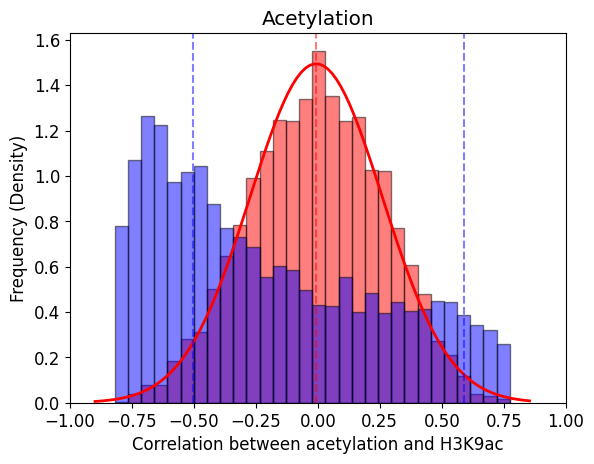

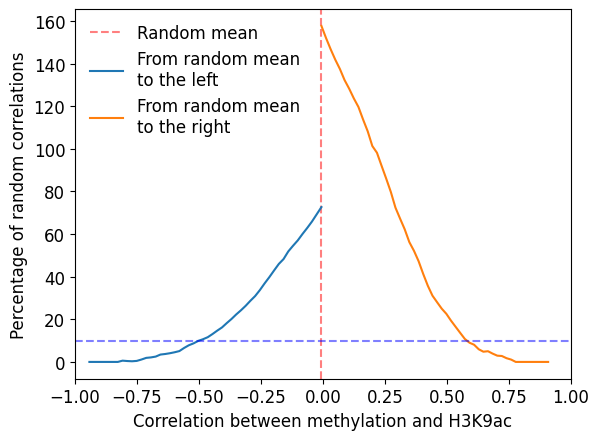

In [103]:
# Increase font sizes
plt.rcParams.update({'font.size': 12})  # Adjust the value as needed

# Generate some random data for the histogram (replace with your data)
random = randomCorrsAc
corrs=corrsAc

# Create the histogram
n,bins,patches=plt.hist(random, bins=30, density=True, alpha=0.5, color='red', edgecolor='black',label="Random")
plt.hist(corrs, bins=bins,density=True, alpha=0.5, color='blue', edgecolor='black',label="Observed")

# Generate x-values for the normal distribution curve
xmin, xmax = plt.xlim()  # Get the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# Calculate the normal distribution curve (mean=0, variance=1)
u=np.mean(random)
var=np.var(random,ddof=1)
p = norm.pdf(x, u,np.sqrt(var))  # norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, p, 'red', linewidth=2)#, label='Normal \ndistribution\n$\hat\mu$='+str(round(u,3))+'\n$\hat\sigma$='+str(round(var,3)))



# Example: Normal distribution with mean 0 and standard deviation 1 (standard normal)
mean = u
std_dev = np.sqrt(var)
alpha = 0.05
print(mean,var)
median = np.median(corrs)

# Right
criticalsR=np.linspace(mean,max(corrs))
percentagesR=[]
show=True
for criticalR in criticalsR:
    a=np.sum(random >= criticalR)
    b=np.sum(corrs >= criticalR)
    percentagesR.append(a/b*100)
    if a/b<=0.1 and show==True: 
        print(criticalR,a,b,a/b)
        cRight = criticalR
        show = False
# Left        
criticalsL=np.linspace(mean,min(corrs))
percentagesL=[]
show=True
for criticalL in criticalsL:
    a=np.sum(random <= criticalL)
    b=np.sum(corrs <= criticalL)
    percentagesL.append(a/b*100)
    if a/b<=0.1 and show==True: 
        print(criticalL,a,b,a/b)
        cLeft = criticalL
        show = False

plt.axvline(x=cRight, color='b', linestyle='--',label="Critical values\n(<10% random)",alpha=0.5)
plt.axvline(x=cLeft, color='b', linestyle='--',alpha=0.5)
plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5,label="Random mean")

# Add labels and title
plt.xlim([-1.1,1])
plt.xlabel('Correlation between acetylation and H3K9ac')
plt.ylabel('Frequency (Density)')
plt.title("Acetylation")
#plt.legend(frameon=False)#,loc='upper left') #show the legend
# Show the plot
plt.xlim([-1,1])
plt.savefig("freqAc.svg")
plt.show()

plt.axvline(x=mean, color='r', linestyle='--',label="Random mean",alpha=0.5)
plt.plot(criticalsL, percentagesL,label="From random mean\nto the left")
plt.plot(criticalsR, percentagesR,label="From random mean\nto the right")
plt.axhline(y=10, color='b', linestyle='--',alpha=0.5)
plt.xlabel('Correlation between methylation and H3K9ac')
plt.ylabel('Percentage of random correlations')
plt.legend(frameon=False)

# Adjust layout for better spacing
# Show the combined plot
plt.xlim([-1,1])
plt.savefig("perAc.svg")
plt.show()